In [1]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd
import seaborn as sns
import nibabel as nib

# from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchio as tio
import networks_gan
import losses
from skimage.metrics import structural_similarity as ssim
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

2023-12-11 15:41:03.798804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 15:41:03.935121: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 15:41:03.938362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-11 15:41:03.938381: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
valid_dataset = RadOncValidationDataset("/home/myi16/jsr_Y/md4_val", num_samples=None, supervision=True,
                                            return_segmentation=True)
device = torch.device('cpu')

In [20]:
valid_dataset = RadOncValidationDataset("/mnt/blackhole-data2/RadOnc_Brain/Validation", num_samples=None, supervision=True,
                                            return_segmentation=True)

device = torch.device('cpu')

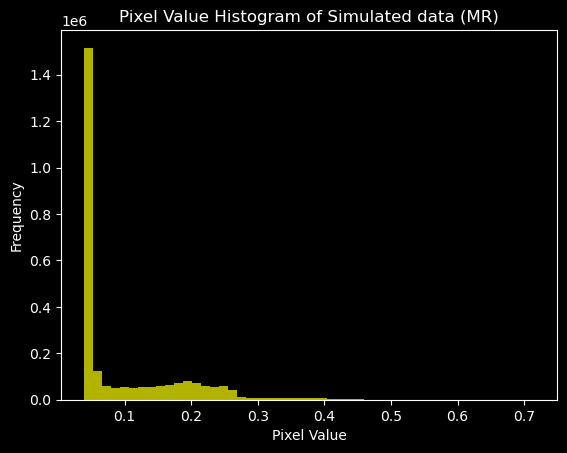

In [13]:
data = valid_dataset[4]
mr = data[1].numpy()
cbct = data[0].numpy()
pix_mr = mr.flatten()
pix_mr = pix_mr[pix_mr>0]
pix_cbct = cbct.flatten()
pix_cbct = pix_cbct[pix_cbct>0]

plt.hist(pix_mr, bins=50, color='yellow', alpha=0.7)
plt.title('Pixel Value Histogram of Simulated data (MR)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()



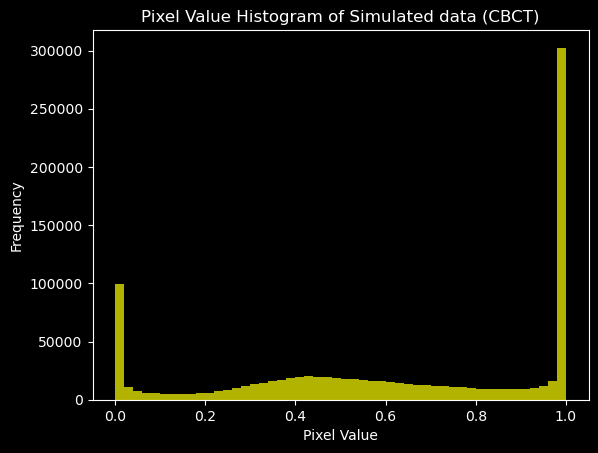

In [16]:

plt.hist(pix_cbct, bins=50, color='yellow', alpha=0.7)
plt.title('Pixel Value Histogram of Simulated data (CBCT)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [9]:
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v3').to(device)
checkpoint = torch.load('JSRCascade_rnewflow_twostage_l1100_multi0.3_reg100_seg6_ep99.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

<All keys matched successfully>

In [2]:
'decoder_reg.flow4.weight'[0:11]

'decoder_reg'

10


  0%|          | 0/10 [00:00<?, ?it/s]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0407) tensor(0.5506)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


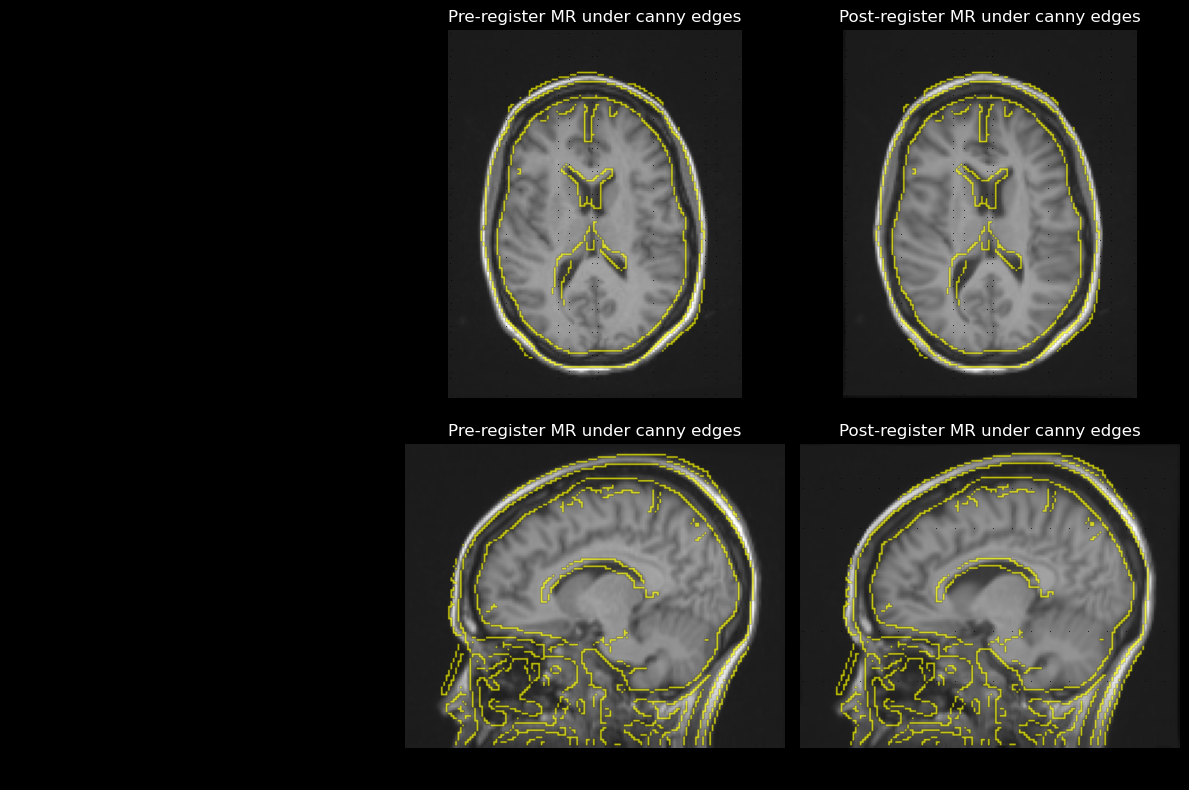

torch.Size([1, 7, 128, 160, 128])


 10%|█         | 1/10 [00:18<02:47, 18.56s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0333) tensor(0.7646)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


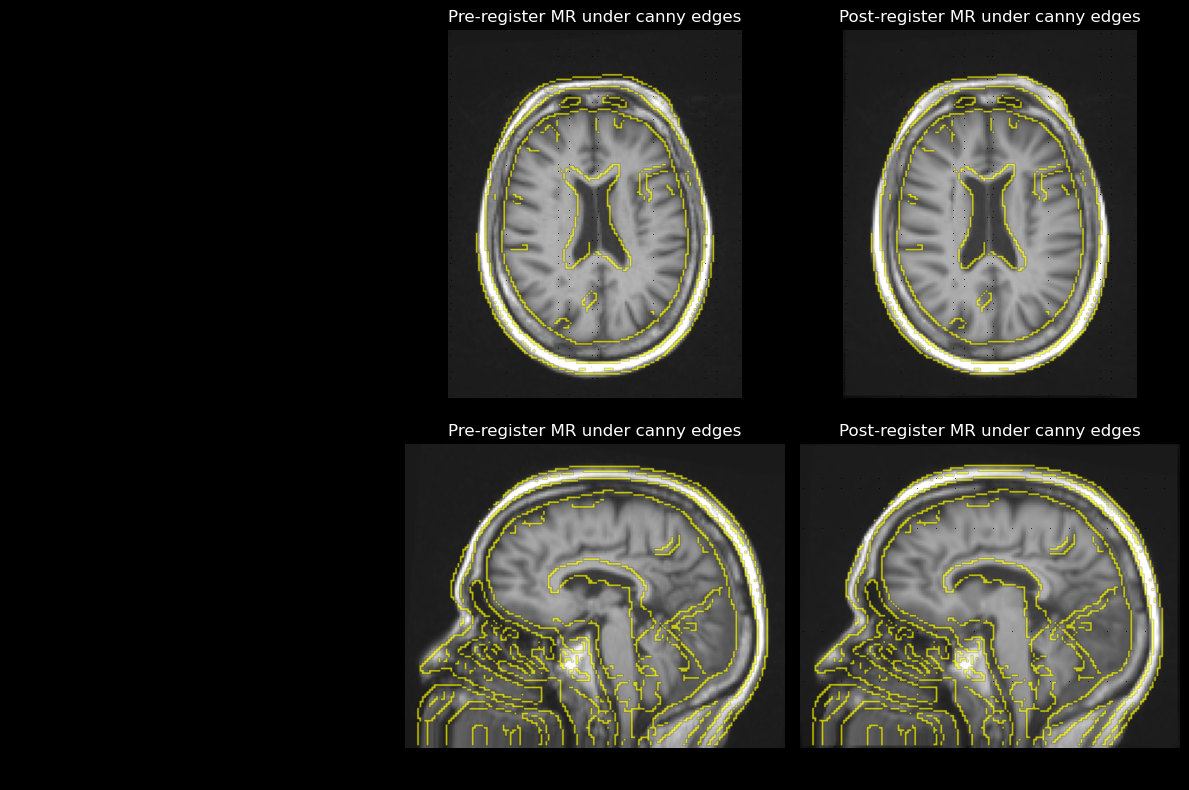

torch.Size([1, 7, 128, 160, 128])


 20%|██        | 2/10 [00:36<02:25, 18.20s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0125) tensor(0.5721)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


torch.Size([1, 7, 128, 160, 128])


 30%|███       | 3/10 [00:53<02:02, 17.46s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0088) tensor(0.5979)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


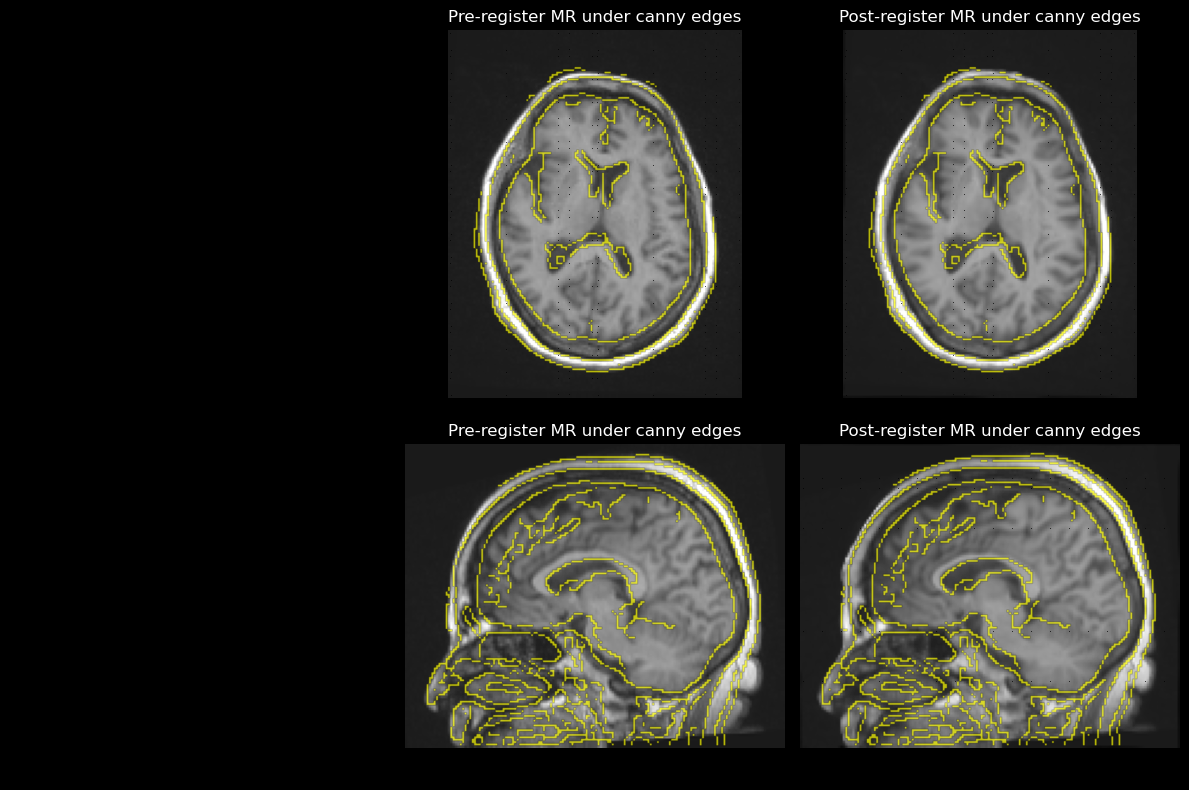

torch.Size([1, 7, 128, 160, 128])


 40%|████      | 4/10 [01:08<01:39, 16.62s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0297) tensor(0.7452)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


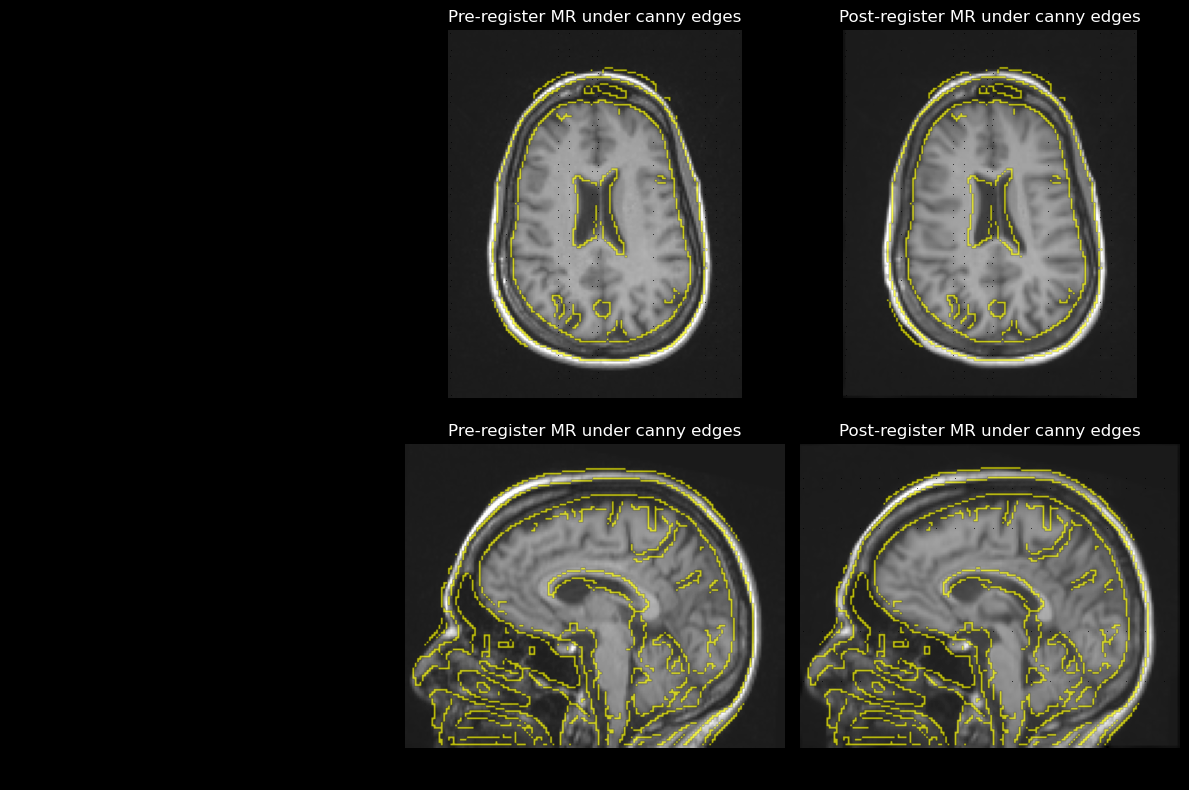

torch.Size([1, 7, 128, 160, 128])


 50%|█████     | 5/10 [01:24<01:21, 16.37s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0405) tensor(0.5650)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


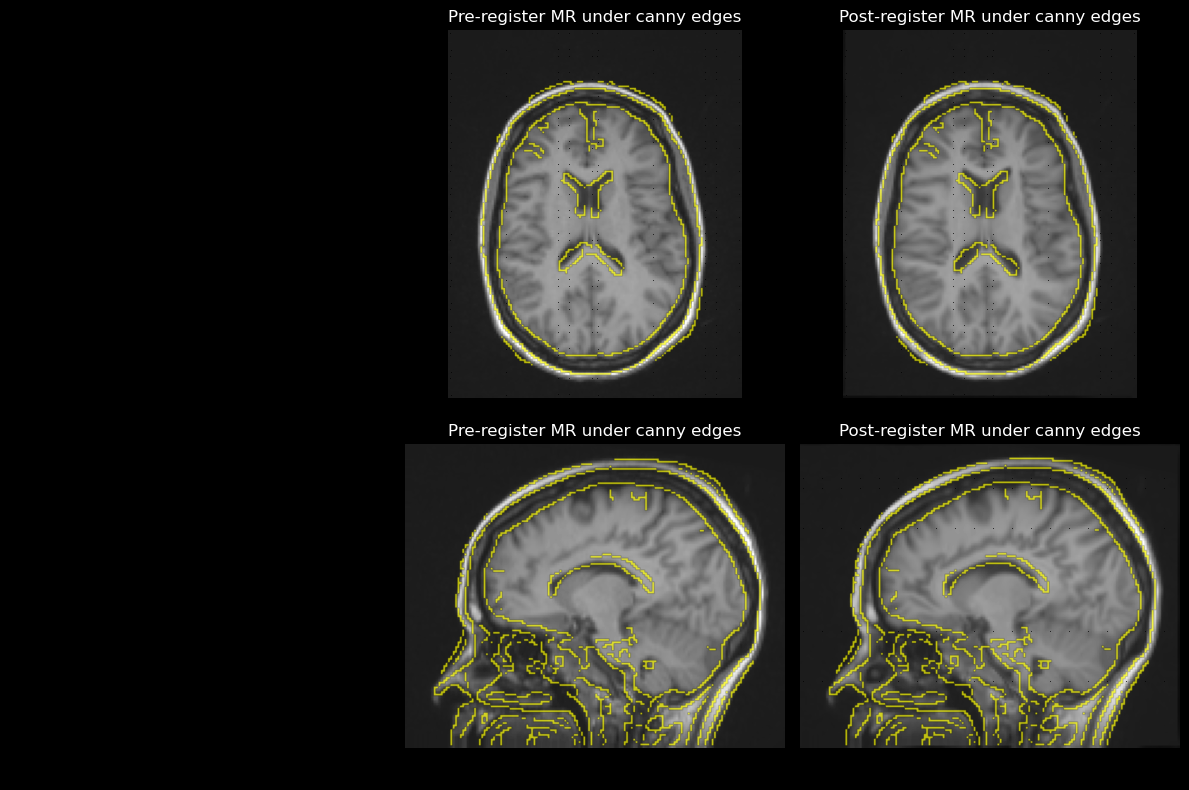

torch.Size([1, 7, 128, 160, 128])


 60%|██████    | 6/10 [01:41<01:05, 16.49s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0377) tensor(0.7758)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


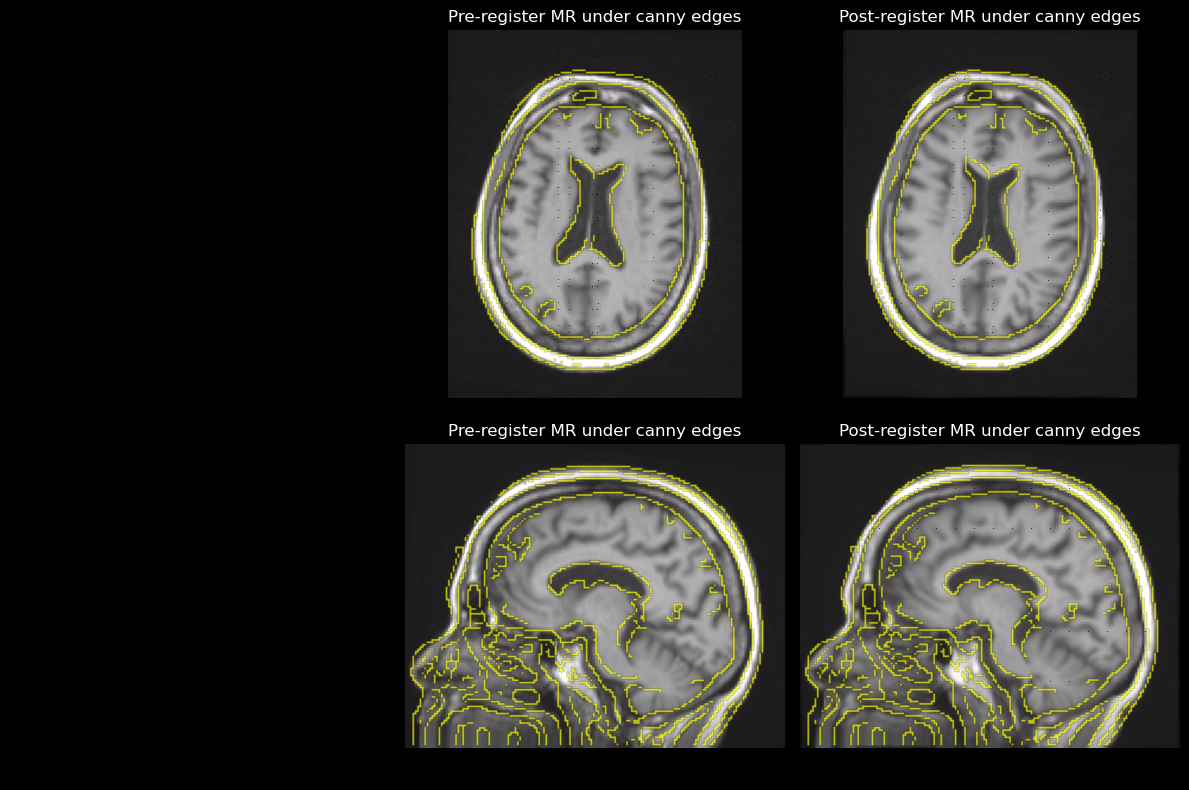

torch.Size([1, 7, 128, 160, 128])


 70%|███████   | 7/10 [01:56<00:48, 16.26s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0403) tensor(0.9536)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


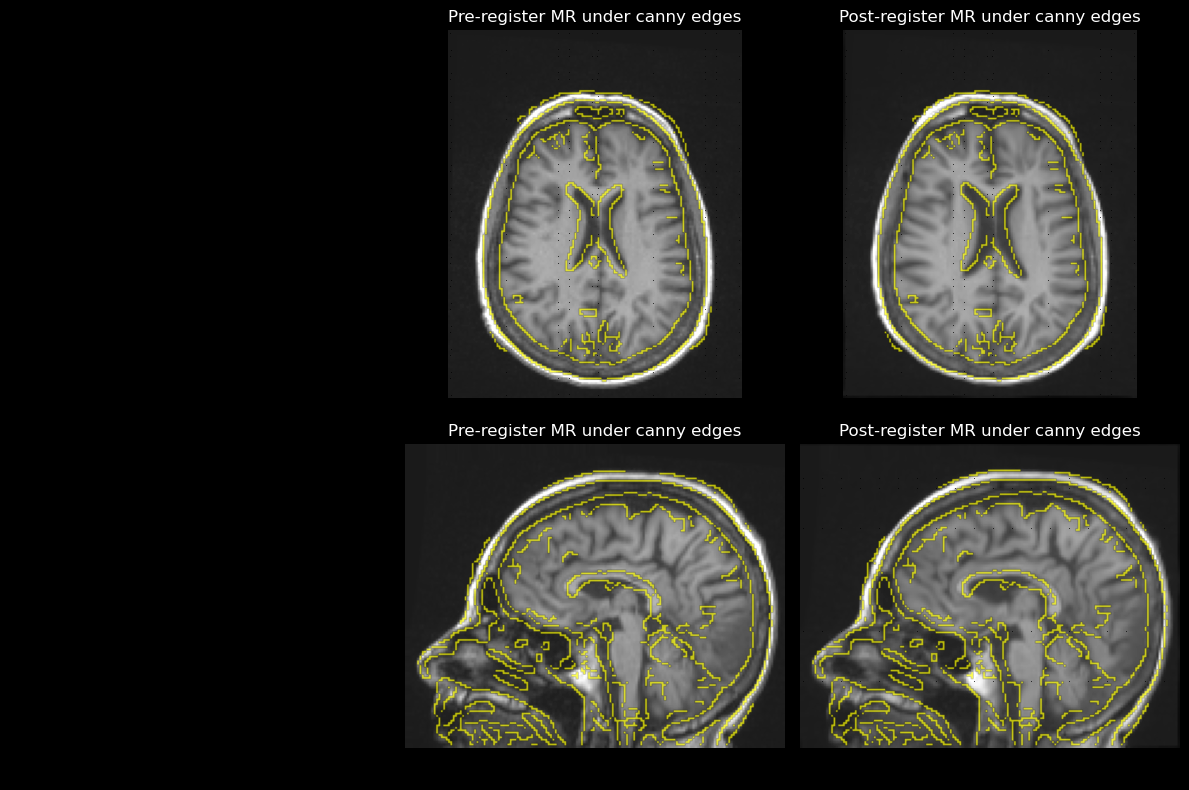

torch.Size([1, 7, 128, 160, 128])


 80%|████████  | 8/10 [02:12<00:31, 15.91s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0402) tensor(0.7379)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


torch.Size([1, 7, 128, 160, 128])


 90%|█████████ | 9/10 [02:27<00:15, 15.69s/it]

cbct: tensor(0.) tensor(1.)
mr: tensor(0.0275) tensor(0.9699)
ct_fixed: tensor(0.) tensor(1.)
ct_moving: tensor(0.) tensor(1.0000)
seg_moving: tensor(0.) tensor(1.)
seg_fixed: tensor(0.) tensor(1.)


torch.Size([1, 7, 128, 160, 128])


100%|██████████| 10/10 [02:42<00:00, 16.27s/it]


In [10]:
metrics = pd.DataFrame()
mask_val = [1,2,23,5,19,29,8]
# valid_dataset = RadOncTrainingDataset("/home/myi16/jsr_Y/new_val", num_samples=10, transform=False,
#                                          supervision=True, return_segmentation=True)
l= len(valid_dataset)
print(len(valid_dataset))
for ep in range(1):
    G.load_state_dict(checkpoint['G_state_dict'])
    dice_before_total = []
    dice_after_total = []
    hd_before_total = []
    sd_before_total = []
    hd_after_total = []
    
    sd_after_total = []
    tre_before_total = []
    tre_after_total = []
    
    for i in tqdm(range(l)):
        cbct_fixed, mr_moving, ct_fixed, ct_moving, seg_fixed, seg_moving= valid_dataset[i]
        cbct_fixed = cbct_fixed.float().to(device)
        mr_moving = mr_moving.float().to(device)
        ct_fixed = ct_fixed.float().to(device)
        ct_moving = ct_moving.float().to(device)
        seg_fixed = seg_fixed.float().to(device)
        seg_moving = seg_moving.float().to(device)
        print('cbct:',cbct_fixed.min(),cbct_fixed.max())
        print('mr:',mr_moving.min(),mr_moving.max())
        print('ct_fixed:',ct_fixed.min(),ct_fixed.max())
        print('ct_moving:',ct_moving.min(),ct_moving.max())
        print('seg_moving:',seg_moving.min(),seg_moving.max())
        print('seg_fixed:',seg_fixed.min(),seg_fixed.max())
        
        # mr_moving = mr_moving.unsqueeze(0).unsqueeze(0)
        # cbct_fixed = cbct_fixed.unsqueeze(0).unsqueeze(0)
        
        islice = 70
        islice_s = 68
        with torch.no_grad():
            # print(mr_moving.shape,cbct_fixed.shape)
            flow, ct_moving_synth, ct_fixed_synth= G(mr_moving, cbct_fixed)
            # print(ct_moving_synth[0].shape,ct_moving_synth[1].shape,ct_moving_synth[2].shape,ct_moving_synth[3].shape)
            # print(ct_fixed_synth[0].shape,ct_fixed_synth[1].shape,ct_fixed_synth[2].shape,ct_fixed_synth[3].shape)
            # the flow[0] means the final highest resolution from the cascade network.
            mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flow[0])
            ct_reg_synth = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(ct_moving_synth[0], flow[0])
            seg_reg = vxm.layers.SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])
            # mr_reg = mr_moving
            # seg_reg = seg_moving
            
            fig, ax = plt.subplots(2,3,figsize=(12,8))
            np.vectorize(lambda ax: ax.axis('off'))(ax)
            
            ax[0, 1].imshow(mr_moving[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            ax[0, 1].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0, 1].set_title('Pre-register MR under canny edges')
            
            ax[0, 2].imshow(mr_reg[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            ax[0, 2].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0, 2].set_title('Post-register MR under canny edges')
            
            ax[1, 1].imshow(torch.flipud(mr_moving[0,0,islice_s,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            ax[1, 1].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1, 1].set_title('Pre-register MR under canny edges')
            
            ax[1, 2].imshow(torch.flipud(mr_reg[0,0,islice_s,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            ax[1, 2].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1, 2].set_title('Post-register MR under canny edges')
            
            # fig, ax = plt.subplots(2,3,figsize=(12,8))
            # np.vectorize(lambda ax: ax.axis('off'))(ax)
            # plt.style.use('dark_background')
            # ax[0, 1].imshow(ct_fixed[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
            # ax[0, 1].set_title('Input CT')
            
            # ax[0, 2].imshow(ct_moving[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
            # ax[0, 2].set_title('Deformed input CT')
            
            # ax[1, 1].imshow(ct_fixed_synth[0][0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
            # ax[1, 1].set_title('Synthesis CT from CBCT')
            
            # ax[1, 2].imshow(ct_moving_synth[0][0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
            # ax[1, 2].set_title('Synthesis CT from MRI')
            
            # ax[1, 1].imshow(torch.flipud(mr_moving[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            # ax[1, 1].set_title('Input MR under canny edges')
            
            # ax[1, 2].imshow(torch.flipud(mr_reg[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            # ax[1, 2].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[1, 2].set_title('Deformed MR under canny edges')           

            plt.tight_layout()
            plt.show()

            dice_before = []
            hd_before = []
            sd_before = []
            dice_after= []
            hd_after = []
            sd_after = []
            print(seg_fixed.shape)
            for j, val in enumerate(mask_val):
                mask_fixed = seg_fixed[:,j:j+1,:,:,:]
                mask_moving = seg_moving[:,j:j+1,:,:,:]
                mask_registered = seg_reg[:,j:j+1,:,:,:]
                dice_before.append(-losses.Dice().loss(mask_fixed,mask_moving).item())
                dice_after.append(-losses.Dice().loss(mask_fixed,mask_registered).item())
                metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_moving.squeeze().cpu().numpy())==1)
                metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_registered.squeeze().cpu().numpy())==1)
                hd_before.append(metrics_before['hd'])
                hd_after.append(metrics_after['hd'])
                sd_before.append(metrics_before['avg_dist'])
                sd_after.append(metrics_after['avg_dist'])
                
            # valid_ds = np.load(glob.glob(os.path.join("/mnt/blackhole-data2/RadOnc_Brain/Validation",'*.npz'))[i])
            # seg_fixed = valid_ds['ventricle_fixed']
            # seg_moving = valid_ds['ventricle_moving']
            # seg_fixed = torch.from_numpy(resize(seg_fixed, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            # seg_moving = torch.from_numpy(resize(seg_moving, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            # seg_reg = vxm.layers.SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])
            # tre_before_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_moving.squeeze().cpu().numpy(), [1,1,1]).mean())
            # tre_after_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_reg.squeeze().cpu().numpy(), [1,1,1]).mean())
            dice_before_total.append(dice_before)
            dice_after_total.append(dice_after)
            hd_before_total.append(hd_before)
            hd_after_total.append(hd_after)
            sd_before_total.append(sd_before)
            sd_after_total.append(sd_after)
    if ep == 0:
        d0 = {'Dice':np.reshape(np.array(dice_before_total),-1), 'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1), 
              'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*l, 'ep':[0]*(7*l), 'method':['Rigid']*(7*l)}
        d0 = pd.DataFrame(data=d0)
        metrics = pd.concat([metrics, d0])

    d = {'Dice':np.reshape(np.array(dice_after_total),-1), 'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1), 
         'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*l, 'ep':[29+ep*10]*(7*l), 'method':['JSR-Cascade']*(7*l)}
    d = pd.DataFrame(data=d)
    metrics = pd.concat([metrics, d])

In [16]:
print('cbct:',cbct_fixed.dtype)
print('mr:',mr_moving.dtype)
print('ct_fixed:',ct_fixed.dtype)
print('ct_moving:',ct_moving.dtype)
print('seg_moving:',seg_moving.dtype)
print('seg_fixed:',seg_fixed.dtype)

cbct: torch.float32
mr: torch.float32
ct_fixed: torch.float32
ct_moving: torch.float32
seg_moving: torch.float32
seg_fixed: torch.float32


In [11]:
for name in ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']:
    data = metrics[metrics['anatomy']==name]
    data = data[data['method']=='JSR-Cascade']
    Dice = data['Dice'].mean()
    HD = data['HD'].mean()
    SD = data['SD'].mean()
    print(name, Dice, HD, SD)

3rd Ventricle 0.13206795305013658 3.219933359557402 1.209441065466262
4th Ventricle 0.2663980655372143 3.56078249894113 1.1308674228320108
Lateral Ventricles 0.5812625110149383 4.843849584291872 0.7470139675330495
Amygdala 0.19933928158134223 3.4826444628404714 1.0040605296530174
Hippocampus 0.3664459303021431 3.835266713263416 0.8151215259758302
Thalamus 0.6445528626441955 3.8390885448212146 0.9647975283666803
Caudate 0.34103901237249373 3.6120020186702844 0.7103464446689269


In [6]:
for name in ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']:
    data = metrics[metrics['anatomy']==name]
    data = data[data['method']=='JSR-Cascade']
    Dice = data['Dice'].std()
    HD = data['HD'].std()
    SD = data['SD'].std()
    print(name, Dice, HD, SD)


3rd Ventricle 0.27374919570565304 1.0022742005330416 0.7684687894380292
4th Ventricle 0.18248411919003232 1.2755323730088526 0.261912716222722
Lateral Ventricles 0.1242333749696644 2.8547653848424774 0.16049074007051606
Amygdala 0.2591329703847876 0.9595727038379919 0.37852408536468096
Hippocampus 0.12889640920823783 0.6610898274773429 0.21592309900007298
Thalamus 0.07851831073892737 1.0872710097836251 0.2937397320704969
Caudate 0.15150496627161394 0.8651955404643642 0.27401026971138304


In [12]:
meand = metrics[metrics['method']=='JSR-Cascade']
meand.mean()

/tmp/ipykernel_50129/1716046569.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meand.mean()


Dice     0.361587
HD       3.770510
SD       0.940235
ep      29.000000
dtype: float64

In [7]:
meand = metrics[metrics['method']=='Rigid']
meand.mean()

/tmp/ipykernel_37635/3042583127.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meand.mean()


Dice    0.309023
HD      3.714354
SD      1.121877
ep      0.000000
dtype: float64

In [13]:

meand.to_csv('base_twostage.csv',index = False)

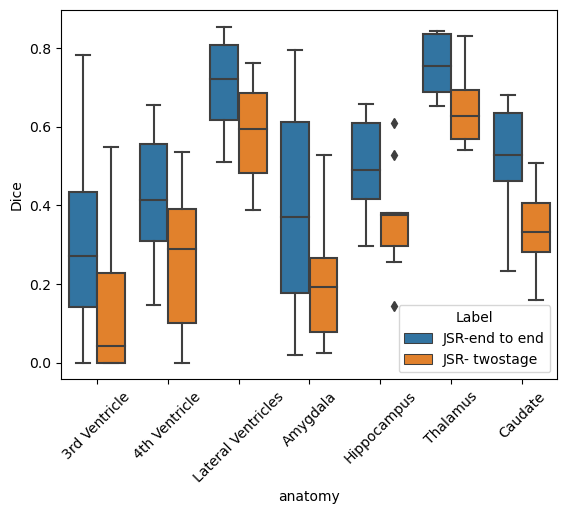

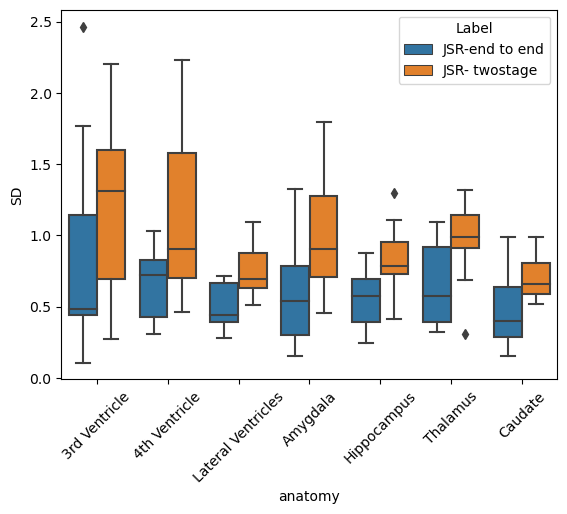

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# data1 = pd.read_csv('trained_with_gtCT.csv')
data2 = pd.read_csv('base_NtoN.csv')
data3 = pd.read_csv('base_twostage.csv')
# data2 = pd.read_csv('lastlayers_seg.csv')
# data4 = pd.read_csv('lastlayers_sim.csv')

organs = ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']
# List of evaluation metrics
metricses = ['Dice', 'HD', 'SD']
plt.style.use('default')
    
# Create box plots for each metric
for i,metric in enumerate(metricses):
    cdf = pd.concat(objs=[data2[metric],data3[[metric,'anatomy']]],axis=1) #],data3[metric],data4[[metric,
    cdf.columns = ['JSR-end to end','JSR- twostage','anatomy']
    mdf = pd.melt(cdf, id_vars=['anatomy'], var_name='Label',value_name=metric)
    axs = sns.boxplot(x="anatomy", y=metric, hue="Label", data=mdf)    
    axs.set_xticklabels(axs.get_xticklabels(), rotation=45)
    plt.show()
    

In [3]:
from scipy import stats
def ttest(group1,group2,name):
    _, norm1 = stats.shapiro(group1)
    _, norm2 = stats.shapiro(group2)
    if norm1 <0.05 or norm2<0.05:
        _,p_value = stats.mannwhitneyu(group1, group2)
        if p_value < 0.05:
            print('There is significant difference in '+name)
        else:
            print('There is no significant difference in '+name)
    else:
        _, var = stats.levene(group1,group2)
        if var> 0.05:
            _, p_value = stats.ttest_ind(group1, group2)
            if p_value < 0.05:
                print('There is significant difference in '+name)
            else:
                print('There is no significant difference in '+name)
        else: 
            _, p_value = stats.ttest_ind(group1, group2, equal_var=False)
            if p_value < 0.05:
                print('There is significant difference in '+name)
            else:
                print('There is no significant difference in '+name)
            
            

In [4]:

# data1 = pd.read_csv('base_comp.csv')
# data3 = pd.read_csv('lastlayers_conv.csv')
# data2 = pd.read_csv('lastlayers_seg.csv')
# data4 = pd.read_csv('lastlayers_sim.csv')

for organ in organs:
    print('For '+organ)
    d1 = data3[data3['anatomy']==organ]
    d2 = data2[data2['anatomy']==organ]
    # d3 = data3[data3['anatomy']==organ]
    # d4 = data4[data4['anatomy']==organ]
    for metric in metricses:
        fd = d1[metric]
        sd = d2[metric]
        # td = d3[metric]
        # ed = d4[metric]
        ttest(fd,sd,metric)
        # print('For Conv:')
        # ttest(fd,td,metric)
        # print('For Sim:')
        # ttest(fd,ed,metric)
        

For 3rd Ventricle
There is no significant difference in Dice
There is no significant difference in HD
There is no significant difference in SD
For 4th Ventricle
There is no significant difference in Dice
There is no significant difference in HD
There is significant difference in SD
For Lateral Ventricles
There is no significant difference in Dice
There is no significant difference in HD
There is significant difference in SD
For Amygdala
There is no significant difference in Dice
There is no significant difference in HD
There is significant difference in SD
For Hippocampus
There is significant difference in Dice
There is no significant difference in HD
There is significant difference in SD
For Thalamus
There is significant difference in Dice
There is no significant difference in HD
There is significant difference in SD
For Caudate
There is significant difference in Dice
There is no significant difference in HD
There is significant difference in SD
